In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.sqrt import UnarySqrt
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def test(rng="Sobol", 
         mode="unipolar", 
         bitwidth=8, 
         jk_trace=False, 
         emit=True, 
         total_cnt=100, 
         depth_kernel=1, 
         depth_emit=3, 
         depth_sync=2, 
         savepdf=False):
    stype = torch.float
    rtype = torch.float
    
    print("========================================================")
    print(mode)
    print("========================================================")
    # all input values are non-negative
    low_bound = 0
    if mode is "unipolar":
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        low_bound = 0
        up_bound = 2**(bitwidth-1)

    input_list = []
    for input_val in range(low_bound, up_bound+1, 1):
        input_list.append(input_val)
    
    input = torch.tensor(input_list).type(torch.float).div(up_bound).to(device)

    output = torch.sqrt(input).to(device)
    outputPE = ProgressiveError(output, mode=mode).to(device)
    
    inputPE  = ProgressiveError(input,  mode=mode).to(device)
    inputSRC = SourceGen(input, bitwidth, mode=mode, rtype=rtype)().to(device)
    
    result_pe_total = []
    for rand_idx in range(1, total_cnt+1):
        dut_sqrt = UnarySqrt(mode=mode, 
                         jk_trace=jk_trace, 
                         depth_kernel=depth_kernel, 
                         rng="Sobol", 
                         rng_dim=4, 
                         emit=emit, 
                         depth_emit=depth_emit, 
                         depth_sync=depth_sync, 
                         stype=torch.float).to(device)
        
        inputRNG = RNG(bitwidth, rand_idx, rng, rtype)().to(device)
        inputBS = BSGen(inputSRC, inputRNG, stype).to(device)
        with torch.no_grad():
            start_time = time.time()
            for i in range(2**bitwidth):
                input_bs = inputBS(torch.tensor([i]))
                inputPE.Monitor(input_bs)

                ouyput_bs = dut_sqrt(input_bs)
                outputPE.Monitor(ouyput_bs)
        
        # get the result for different rng
        result_pe = outputPE()[1].cpu().numpy()
        result_pe = result_pe.flatten()
        result_pe_total.append(result_pe)
    
    # get the result for different rng
    result_pe_total = np.array(result_pe_total)
    
    #######################################################################
    # check the error of all simulation
    #######################################################################
    print("RMSE:{:1.4}".format(math.sqrt(np.mean(result_pe_total**2))))
    print("MAE: {:1.4}".format(np.mean(np.abs(result_pe_total))))
    print("bias:{:1.4}".format(np.mean(result_pe_total)))
    print("max: {:1.4}".format(np.max(result_pe_total)))
    print("min: {:1.4}".format(np.min(result_pe_total)))

    #######################################################################
    # check the error according to input value
    #######################################################################
    max_total = np.max(result_pe_total, axis=0)
    min_total = np.min(result_pe_total, axis=0)
    avg_total = np.mean(result_pe_total, axis=0)
    
    axis_len = outputPE()[1].size()[0]
    input_x_axis = []
    for axis_index in range(axis_len):
        input_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
    fig, ax = plt.subplots()
    ax.fill_between(input_x_axis, max_total, avg_total, facecolor="red", alpha=0.75)
    ax.fill_between(input_x_axis, avg_total, min_total, facecolor="blue", alpha=0.75)
    ax.plot(input_x_axis, avg_total, label='Avg error', color="black", linewidth=0.3)
    plt.tight_layout()
    plt.xlabel('Input value')
    plt.ylabel('Output error')
    plt.xticks(np.arange(0, 1.1, step=0.5))
    # ax.xaxis.set_ticklabels([])
    plt.xlim(0, 1)
    plt.yticks(np.arange(-0.2, 0.4, step=0.2))
    # ax.yaxis.set_ticklabels([])
    plt.ylim(-0.3, 0.55)
    plt.grid(b=True, which="both", axis="y", linestyle="--", color="grey", linewidth=0.3)
    fig.set_size_inches(4, 2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if savepdf is True:
        if emit is True:
            plt.savefig(mode+"-bw"+str(bitwidth)+"-bit"+"-emitting"+"-s"+str(depth_sync)+"-k"+str(depth_kernel)+"-e"+str(depth_emit)+".pdf", 
                        dpi=300, 
                        bbox_inches='tight')
        else:
            if jk_trace is True:
                plt.savefig(mode+"-bw"+str(bitwidth)+"-bit"+"-inserting-JK"+".pdf", 
                            dpi=300, 
                            bbox_inches='tight')
            else:
                plt.savefig(mode+"-bw"+str(bitwidth)+"-bit"+"-inserting-IS"+"-k"+str(depth_kernel)+".pdf", 
                            dpi=300, 
                            bbox_inches='tight')
    plt.show()
    plt.close()

# Following code is to test the best configuration for bit-emit sqrt
## The conclusion is that depth_kernel=1, depth_emit=3, depth_sync=2 is the best for different source rngs

111
unipolar
RMSE:0.06236
MAE: 0.04028
bias:-0.03077
max: 0.0413
min: -0.17


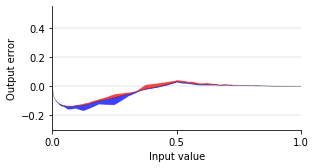

121
unipolar
RMSE:0.06236
MAE: 0.04028
bias:-0.03077
max: 0.0413
min: -0.17


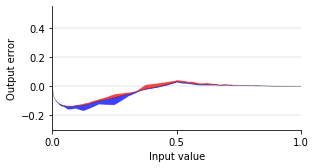

122
unipolar
RMSE:0.04942
MAE: 0.03765
bias:0.02673
max: 0.1178
min: -0.1104


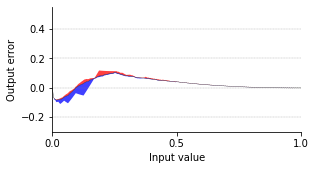

132
unipolar
RMSE:0.04942
MAE: 0.03765
bias:0.02673
max: 0.1178
min: -0.1104


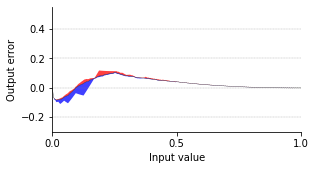

142
unipolar
RMSE:0.04942
MAE: 0.03765
bias:0.02673
max: 0.1178
min: -0.1104


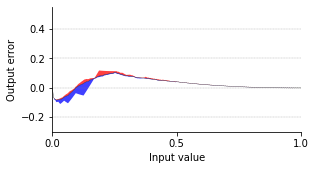

133
unipolar
RMSE:0.07626
MAE: 0.05415
bias:0.05173
max: 0.1977
min: -0.08203


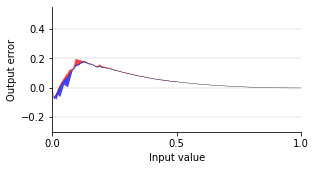

144
unipolar
RMSE:0.0959
MAE: 0.06574
bias:0.06466
max: 0.2407
min: -0.08058


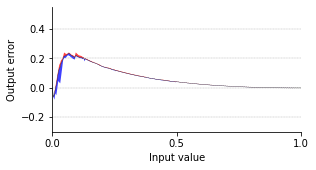

211
unipolar
RMSE:0.06726
MAE: 0.03133
bias:0.02616
max: 0.5
min: -0.1559


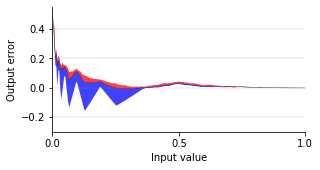

221
unipolar
RMSE:0.06637
MAE: 0.03389
bias:0.02965
max: 0.5
min: -0.1559


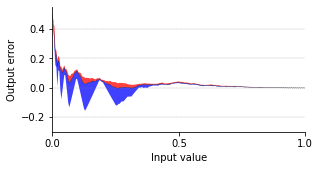

222
unipolar
RMSE:0.05725
MAE: 0.04335
bias:0.03705
max: 0.124
min: -0.08303


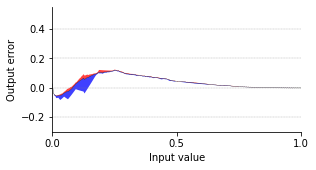

232
unipolar
RMSE:0.05725
MAE: 0.04335
bias:0.03705
max: 0.124
min: -0.08303


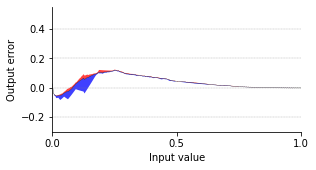

242
unipolar
RMSE:0.05725
MAE: 0.04335
bias:0.03705
max: 0.124
min: -0.08303


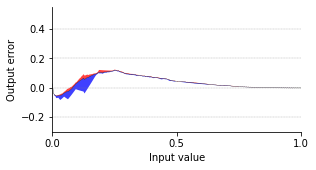

233
unipolar
RMSE:0.08577
MAE: 0.06156
bias:0.06036
max: 0.2094
min: -0.05469


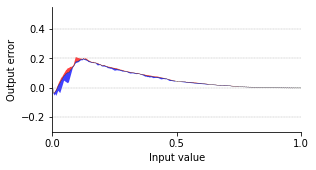

244
unipolar
RMSE:0.1045
MAE: 0.07291
bias:0.07232
max: 0.2679
min: -0.05323


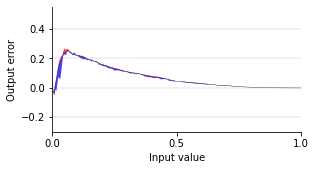

411
unipolar
RMSE:0.1214
MAE: 0.0692
bias:0.06902
max: 0.5
min: -0.002034


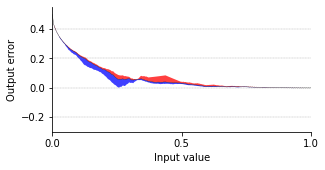

421
unipolar
RMSE:0.1271
MAE: 0.0758
bias:0.07561
max: 0.5
min: -0.002034


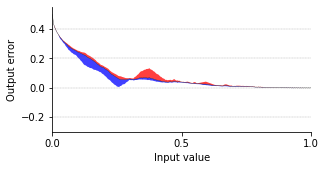

422
unipolar
RMSE:0.1099
MAE: 0.07543
bias:0.07516
max: 0.5117
min: -0.04297


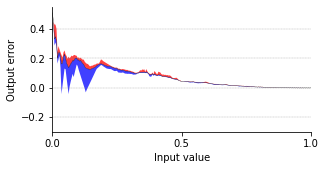

432
unipolar
RMSE:0.0936
MAE: 0.06849
bias:0.06817
max: 0.2193
min: -0.03906


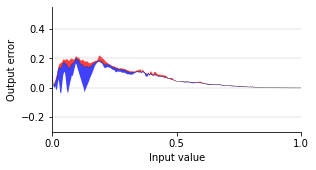

442
unipolar
RMSE:0.0936
MAE: 0.06849
bias:0.06817
max: 0.2193
min: -0.03906


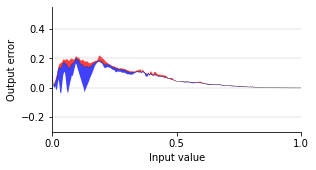

433
unipolar
RMSE:0.1032
MAE: 0.0741
bias:0.07392
max: 0.2394
min: -0.003906


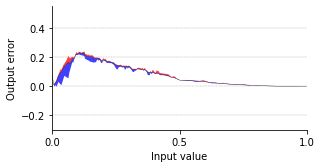

444
unipolar
RMSE:0.1185
MAE: 0.08345
bias:0.08328
max: 0.2846
min: -0.002451


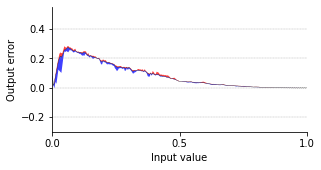

In [5]:
rng="Sobol"
mode="unipolar"
print("111")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=1, depth_sync=1)
print("121")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=2, depth_sync=1)
print("122")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=2, depth_sync=2)
print("132")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=3, depth_sync=2)
print("142")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=4, depth_sync=2)
print("133")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=3, depth_sync=3)
print("144")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=4, depth_sync=4)
print("211")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=1, depth_sync=1)
print("221")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=2, depth_sync=1)
print("222")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=2, depth_sync=2)
print("232")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=3, depth_sync=2)
print("242")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=4, depth_sync=2)
print("233")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=3, depth_sync=3)
print("244")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=4, depth_sync=4)
print("411")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=1, depth_sync=1)
print("421")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=2, depth_sync=1)
print("422")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=2, depth_sync=2)
print("432")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=3, depth_sync=2)
print("442")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=4, depth_sync=2)
print("433")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=3, depth_sync=3)
print("444")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=4, depth_sync=4)

111
bipolar
RMSE:0.0775
MAE: 0.051
bias:-0.04983
max: 0.03739
min: -0.1739


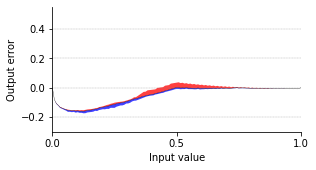

121
bipolar
RMSE:0.0775
MAE: 0.051
bias:-0.04983
max: 0.03739
min: -0.1739


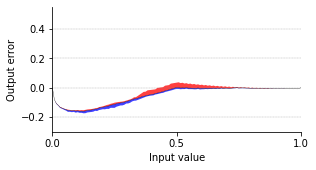

122
bipolar
RMSE:0.04335
MAE: 0.02914
bias:-0.005611
max: 0.04534
min: -0.1484


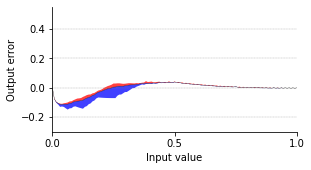

132
bipolar
RMSE:0.04335
MAE: 0.02914
bias:-0.005611
max: 0.04534
min: -0.1484


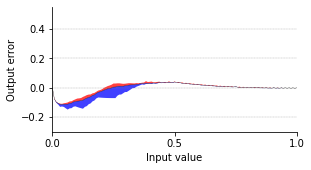

142
bipolar
RMSE:0.04335
MAE: 0.02914
bias:-0.005611
max: 0.04534
min: -0.1484


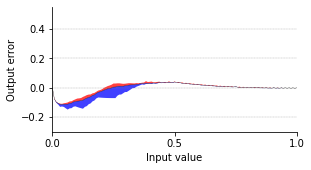

133
bipolar
RMSE:0.05184
MAE: 0.03857
bias:0.02988
max: 0.1451
min: -0.1143


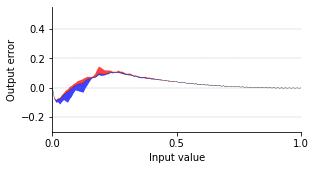

144
bipolar
RMSE:0.07654
MAE: 0.0544
bias:0.05105
max: 0.1938
min: -0.1016


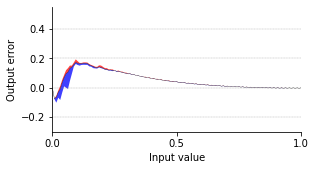

211
bipolar
RMSE:0.05244
MAE: 0.0213
bias:-0.002933
max: 0.5
min: -0.1218


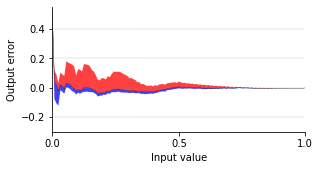

221
bipolar
RMSE:0.05193
MAE: 0.02192
bias:-0.008758
max: 0.5
min: -0.1218


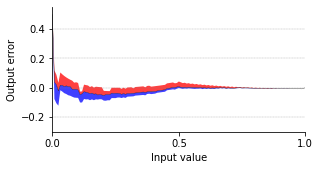

222
bipolar
RMSE:0.04145
MAE: 0.02926
bias:0.0003473
max: 0.07373
min: -0.1484


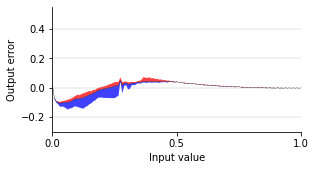

232
bipolar
RMSE:0.04145
MAE: 0.02926
bias:0.0003473
max: 0.07373
min: -0.1484


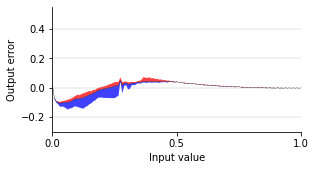

242
bipolar
RMSE:0.04145
MAE: 0.02926
bias:0.0003473
max: 0.07373
min: -0.1484


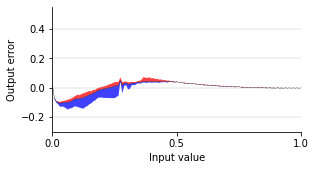

233
bipolar
RMSE:0.05377
MAE: 0.04006
bias:0.032
max: 0.1451
min: -0.1143


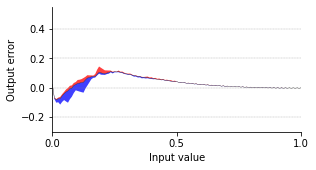

244
bipolar
RMSE:0.07926
MAE: 0.05621
bias:0.05305
max: 0.1938
min: -0.1016


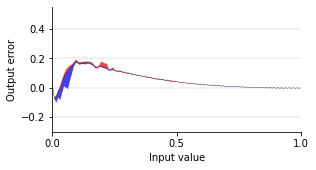

411
bipolar
RMSE:0.1167
MAE: 0.06159
bias:0.05856
max: 0.5
min: -0.008833


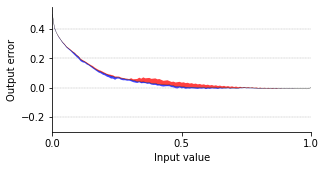

421
bipolar
RMSE:0.1139
MAE: 0.05905
bias:0.05685
max: 0.5
min: -0.007782


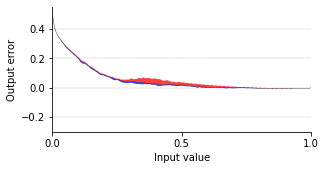

422
bipolar
RMSE:0.07136
MAE: 0.03812
bias:0.03296
max: 0.5078
min: -0.1301


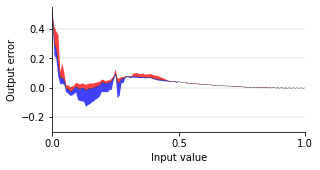

432
bipolar
RMSE:0.04622
MAE: 0.03443
bias:0.02038
max: 0.125
min: -0.125


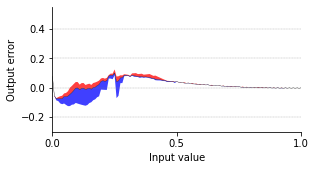

442
bipolar
RMSE:0.04622
MAE: 0.03443
bias:0.02038
max: 0.125
min: -0.125


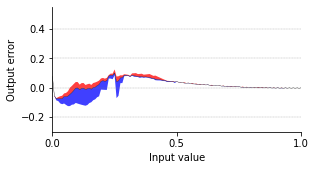

433
bipolar
RMSE:0.06399
MAE: 0.04702
bias:0.04087
max: 0.1451
min: -0.09084


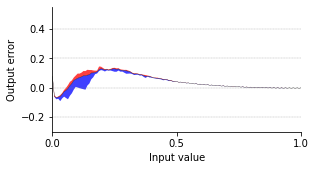

444
bipolar
RMSE:0.08859
MAE: 0.06248
bias:0.06011
max: 0.2173
min: -0.07812


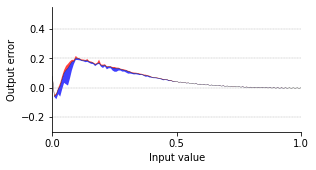

In [6]:
rng="Sobol"
mode="bipolar"
print("111")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=1, depth_sync=1)
print("121")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=2, depth_sync=1)
print("122")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=2, depth_sync=2)
print("132")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=3, depth_sync=2)
print("142")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=4, depth_sync=2)
print("133")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=3, depth_sync=3)
print("144")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=1, depth_emit=4, depth_sync=4)
print("211")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=1, depth_sync=1)
print("221")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=2, depth_sync=1)
print("222")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=2, depth_sync=2)
print("232")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=3, depth_sync=2)
print("242")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=4, depth_sync=2)
print("233")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=3, depth_sync=3)
print("244")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=2, depth_emit=4, depth_sync=4)
print("411")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=1, depth_sync=1)
print("421")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=2, depth_sync=1)
print("422")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=2, depth_sync=2)
print("432")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=3, depth_sync=2)
print("442")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=4, depth_sync=2)
print("433")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=3, depth_sync=3)
print("444")
test(rng=rng, mode=mode, bitwidth=8, emit=True, jk_trace=False, total_cnt=10, depth_kernel=4, depth_emit=4, depth_sync=4)